# Import Dependencies

In [0]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
import time
import zipfile
from IPython import display
import os
import cv2
from matplotlib import image

# Hyperparameters

In [0]:
#### HYPER PARAMETERS
BATCH_SIZE = 50
EPOCHS = 5000
noise_dim = 100
BUFFER_SIZE = 60000

# Set to True if you want to load data and save models to Google Drive
# Set to False if you want to load and save locally.
load_data_from_Google_Drive = True

# Name of dataset zip file without .zip extension
Dataset = "CT_COVID"

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([1, noise_dim])

# Mount Google Drive
To get access to dataset and for model saving  
Runs IF `load_data_from_Google_Drive` is true

In [0]:
if load_data_from_Google_Drive:
  from google.colab import drive
  drive.mount('/content/gdrive')

# Unzip and create dataset with images

Extract data from zip file.  
Assumes all images are in "My Drive" that was mounted in the form of a zip file with name (without .zip extension) specified by "Dataset"

In [0]:
if load_data_from_Google_Drive:
  filepath = "/content/gdrive/My Drive/COVID-19-Affected Lung CT Generative Network"
  os.system("mkdir -p \"/content/gdrive/My Drive/COVID_GAN_Saved_Models\"")
  destination = "/gdrive/Data"
  save_destination = "/content/gdrive/My Drive/COVID_GAN_Saved_Models"
else:
  filepath = os.getcwd()
  destination = os.getcwd()+"/Data"
  os.system("mkdir -p "+os.getcwd()+"/Saved_Models")
  save_destination = os.getcwd() + "/Saved_Models"

# Will unzip the files so that you can see them..
with zipfile.ZipFile(filepath+"/"+Dataset+".zip","r") as z:
    z.extractall(destination)

Read image data in from unzipped directory

In [0]:
# link used: https://www.pyimagesearch.com/2019/01/14/machine-learning-in-python/
os.chdir(destination + "/" + Dataset)

path = "*.*"
data = []
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    data.append(img_data)  
data = np.array(data)

Convert images to proper size and format.  
Also, add horizontally flipped image to double the size of the dataset

In [0]:
from skimage.color import rgb2gray
WIDTH=128
HEIGHT=128
standardized_data = []
for img in data:
  img = rgb2gray(img)
  img2 = np.flip(img, axis=1) ## ADD FLIPPED IMAGE FOR LARGER DATA SET
  standardized_data.append(cv2.resize(img, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
  standardized_data.append(cv2.resize(img2, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
train_images = np.array(standardized_data)
train_images = train_images.reshape(train_images.shape[0], 128,128,1).astype('float32')
print(train_images.shape)

Normalize Images to [-1,1]

In [0]:
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
checker = train_images # np.reshape(train_images, (2164,28,28))
plt.imshow(checker[5,:,:,0])

os.system("rm -r \""+destination+"\"")

# Defining the Model

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 1)

    model.add(layers.Flatten())
    model.add(layers.Dense(128*128, use_bias=False, activation = 'tanh'))
    model.add(layers.Reshape((128,128,1)))
    print(model.output_shape)

    return model

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    assert model.output_shape == (None, 4, 4, 1024)
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64))
    model.add(layers.Dense(32))
    model.add(layers.Dense(16))
    model.add(layers.Dense(1, activation="sigmoid"))

    opt = tf.keras.optimizers.Adam(1e-4)
    model.compile(loss = 'binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [0]:
def make_gan(g_model, d_model):
  d_model.trainable = False
  model = tf.keras.Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = tf.keras.optimizers.Adam(1e-4)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [0]:
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = np.ones((n_samples, 1))
  return X,y

In [0]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim*n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [0]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  X = g_model.predict(x_input)
  y = np.zeros((n_samples, 1))
  return X,y

# Define Training Protocol

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size):
  genLoss = 0
  discLoss = 0
  batch_per_epoch = int(dataset.shape[0]/batch_size)
  half_batch = int(batch_size/2)
  best_g_model = g_model
  best_genLoss = 10
  for epoch in range(n_epochs):
    start = time.time()
    for i in range(batch_per_epoch):
      X_real, y_real = generate_real_samples(dataset,half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)

      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

      discLoss = (d_loss1 + d_loss2)/2

      X_gan = generate_latent_points(latent_dim, batch_size)
      y_gan = np.ones((batch_size, 1))
      genLoss = gan_model.train_on_batch(X_gan, y_gan)
  
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(g_model,
                             epoch + 1,
                             seed)
    
    ### PERFORMANCE CHECK
    X_real, y_real = generate_real_samples(dataset, 100)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, 100)
    _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    print("Disc Accuracy Real: %.5f, fake: %.5f" % (acc_real, acc_fake))
    print("genloss: {} discloss: {}".format(genLoss, discLoss))
    if (epoch > 2./3. * n_epochs):
      if (genLoss < best_genLoss and acc_real > 0.9 and acc_fake > 0.9):
        best_genLoss = genLoss
        best_g_model = g_model

    # Save the model every 100 epochs
    if epoch%100 == 0:
      g_model.save(save_destination+"/generator_intermediate.h5")
      d_model.save(save_destination+"/discriminator_intermediate.h5")

    genloss.append(genLoss)
    discloss.append(discLoss)
    accReal.append(acc_real)
    accFake.append(acc_fake)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(g_model,
                           n_epochs,
                           seed)
  return best_g_model

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.show()

# Perform Training

In [0]:
genloss = []
discloss = []
accReal = []
accFake = []
d_model = make_discriminator_model()
g_model = make_generator_model()
gan_model = make_gan(g_model, d_model)
generator = train(g_model, d_model, gan_model, train_images, noise_dim, EPOCHS, BATCH_SIZE)

g_model.save(save_destination+"/generator_final.h5")
d_model.save(save_destination+"/discriminator_final.h5")
gan_model.save(save_destination+"/gan_final.h5")

# Explore Results

Line Plots of the generator and discriminator loss over epochs

In [0]:
plt.plot(range(EPOCHS), discloss, label='disc loss')
plt.plot(range(EPOCHS), genloss, label='gen loss')
plt.xlabel('Epoch')
plt.ylim(-1,5)
plt.ylabel('Loss value') 
plt.legend()
plt.show()

Line Plots of the discrimiantor accuracy on real and fake images over epochs

In [0]:
plt.plot(range(EPOCHS), accReal, label='accuracy Real')
plt.plot(range(EPOCHS), accFake, label='accuracy Fake')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Generate Random Images

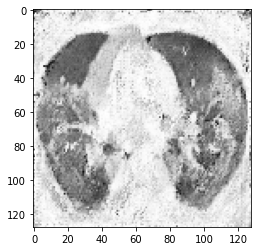

In [21]:
noise = tf.random.normal([1, 100])
generated_image0 = generator.predict(noise)

plt.imshow(generated_image0[0, :, :, 0], cmap='gray')
plt.show()